In [2]:
# importar bibliotecas 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from config import Config
from src.data_processing import DataDict, ItemDict
import json

from utils import plot_hist_with_tukey

pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)


from IPython.display import display

In [3]:
# diretório dos dados
data_dirs = Config.get_path_dir_data()
# caminho para o arquivo csv da variáveis e suas categorias
path_dict = data_dirs["DICIONÁRIO"]["MICRODADOS_ENEM_2023.csv"]

# caminho para os microdados do enem 2023
path_microdados = data_dirs["DADOS"]["MICRODADOS_ENEM_2023.csv"]
# caminho para os itens das provas
path_itens = data_dirs["DADOS"]["ITENS_PROVA_2023.csv"]

# Caminho para o dicionário de variveis dos microdados
path_dict_microdados = data_dirs["DICIONÁRIO"]["MICRODADOS_ENEM_2023.csv"]
# Caminho para o dicionário de variveis dos microdados
path_dict_itens = data_dirs["DICIONÁRIO"]["ITENS_PROVA_2023.csv"]

In [4]:
dir_data = data_dirs["DADOS"]
dir_parquet_data = dir_data["MICRODADOS_ENEM_2023_parquet"]
path_parquet_file = dir_data["MICRODADOS_ENEM_2023.parquet"]
path_parquet_itens = dir_data["ITENS_PROVA_2023.parquet"]

In [5]:
list_parquet = list(dir_parquet_data.list_file().values())

## **Dicionário das variáveis**

In [6]:
dict_microdados = DataDict(path_dict_microdados)
dict_itens = ItemDict(path_dict_itens)

## **Carregar dados**

### **Carregar Microdado enem**

In [ ]:
df = pd.read_parquet(path_parquet_file)

In [7]:
df1 = pd.read_parquet(list_parquet[0])
df2 = pd.read_parquet(list_parquet[0])
df = pd.concat([df1,df2])

### **Carregar Itens**

In [8]:
df_items = pd.read_parquet(path_parquet_itens)

# **Perguntas**

### **"O tipo de escola afeta a nota dos alunos em matemática? Isso pode evidenciar a disparidade de notas no ambiente rural e urbano?"**

In [9]:
# variáveis importantes
var_names_escola_local = ['TP_ESCOLA', 'TP_LOCALIZACAO_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_MT']

In [10]:
# descricao das variáveis
df_descricao_vars = dict_microdados.tabel[["Nome da variavel","Descricao"]]
df_descricao_vars = df_descricao_vars[df_descricao_vars["Nome da variavel"].isin(var_names_escola_local)]
df_descricao_vars

,Nome da variavel,Descricao
9,TP_ESCOLA,Tipo de escola do Ensino Médio
17,TP_DEPENDENCIA_ADM_ESC,Dependência administrativa (Escola)
18,TP_LOCALIZACAO_ESC,Localização (Escola)
37,NU_NOTA_MT,Nota da prova de Matemática


In [11]:
# tipo de dados
for var in var_names_escola_local:
    print(df[var].dtype)

int64
float64
float64
float64


In [12]:
# data frame
df_group = df[var_names_escola_local]
df_group.dropna(subset=var_names_escola_local, inplace=True)
df_group = df_group[df_group['NU_NOTA_MT'] > 0]

/tmp/ipykernel_25529/2098427666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group.dropna(subset=var_names_escola_local, inplace=True)


In [13]:
# legenda dos dados clssificados
for var in var_names_escola_local[:-1]:
    print(f"Variável : {var}")
    display(dict_microdados.legenda[var])

Variável : TP_ESCOLA


,categoria,descricao
0,1,Não Respondeu
1,2,Pública
2,3,Privada


Variável : TP_LOCALIZACAO_ESC


,categoria,descricao
0,1,Urbana
1,2,Rural


Variável : TP_DEPENDENCIA_ADM_ESC


,categoria,descricao
0,1,Federal
1,2,Estadual
2,3,Municipal
3,4,Privada


In [14]:
# filtrar tipos de escolas para pública ou privada
df_group = df_group[df_group["TP_ESCOLA"].isin([2,3])]

In [15]:
types_dict = {}
for var in var_names_escola_local[:-1]:
    df_category:pd.DataFrame = dict_microdados.legenda[var]
    dict_category =  {int(key) : value for key, value in zip(df_category["categoria"].values, df_category["descricao"].values)}
    types_dict[var] = dict_category 

In [16]:
# mapear     

for var in var_names_escola_local[:-1]:
    df_group[var] = df_group[var].map(types_dict[var])

In [17]:
df_group_by = df_group.groupby(['TP_LOCALIZACAO_ESC', 'TP_DEPENDENCIA_ADM_ESC'])["NU_NOTA_MT"]
medias_notas = df_group_by.mean().unstack()
std_notas = df_group_by.std().unstack()

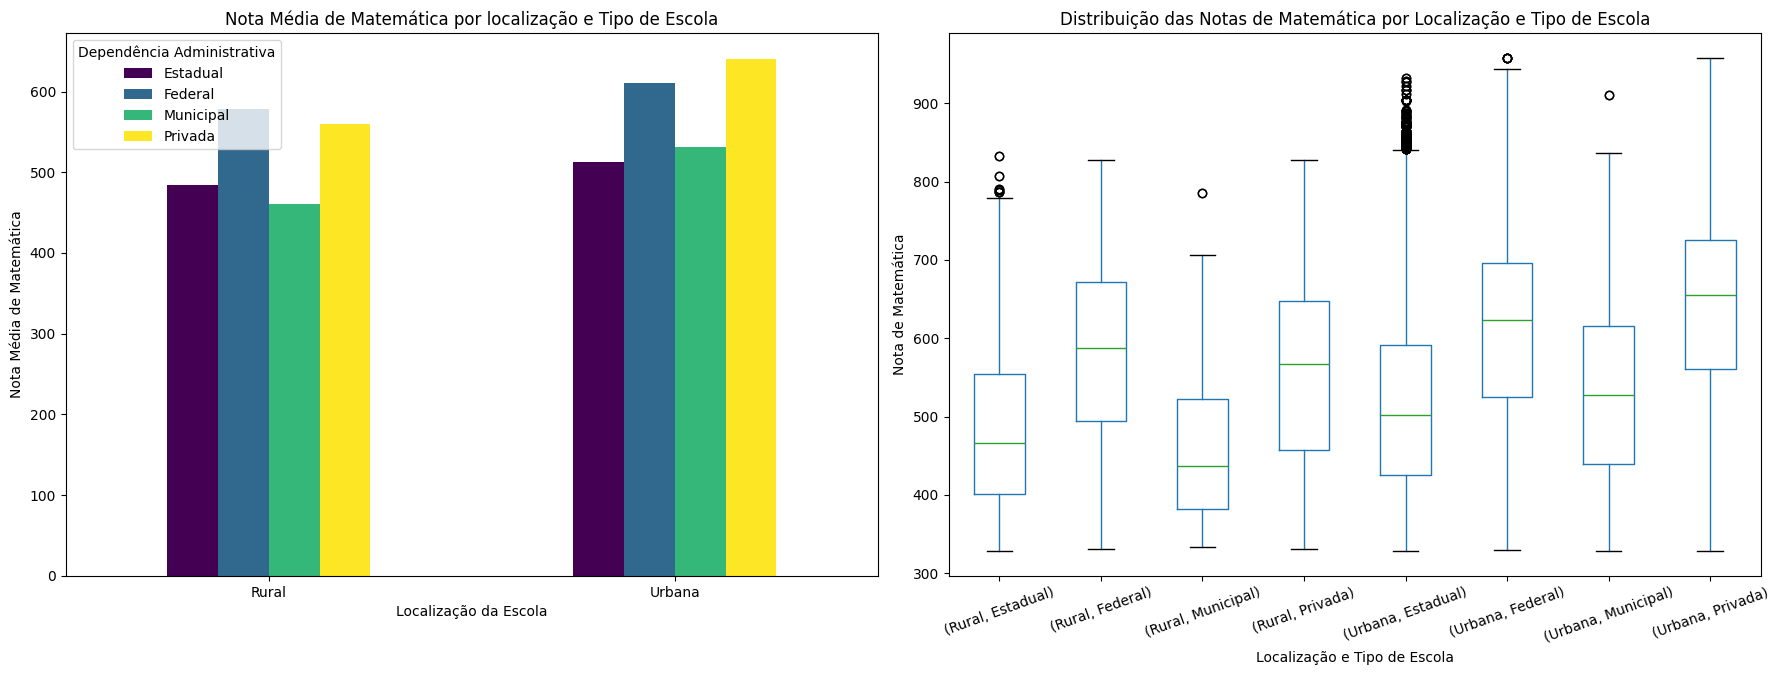

In [18]:
fig, axes_bar_box = plt.subplots(1,2, figsize=(18, 7))

medias_notas.plot(kind='bar', ax=axes_bar_box[0], colormap='viridis')
axes_bar_box[0].set_title("Nota Média de Matemática por localização e Tipo de Escola")
axes_bar_box[0].set_xlabel('Localização da Escola')
axes_bar_box[0].set_ylabel('Nota Média de Matemática')
axes_bar_box[0].legend(title="Dependência Administrativa")
axes_bar_box[0].tick_params(axis='x', rotation=0)

df_group.boxplot(column="NU_NOTA_MT", by=['TP_LOCALIZACAO_ESC', 'TP_DEPENDENCIA_ADM_ESC'],
                 ax=axes_bar_box[1], figsize=(10, 6), grid=False, rot=20)
axes_bar_box[1].set_title('Distribuição das Notas de Matemática por Localização e Tipo de Escola')
axes_bar_box[1].set_xlabel('Localização e Tipo de Escola')
axes_bar_box[1].set_ylabel('Nota de Matemática')
fig.suptitle('')

plt.tight_layout()
plt.show()

Em um primeiro momento, é perceptível a partir da nota média em matemática, as diferenças qualitativas entre as escolas localizadas no meio urbano e as localizadas no meio rural. A Partir disso, podemos refletir sobre diversos aspectos socioeconômicos que atingem a esfera de localização. É visível que, além da mera ideia de que a escola com administração privada tem melhor desempenho, é possível enxergar que a qualidade do ensino também tem um viés de local, uma vez que a escola federal, no meio rural, tem notas maiores que escolas privadas. Isso pode evidenciar que a qualidade do ensino privado no meio rural é inferior ao ensino privado no meio urbano.

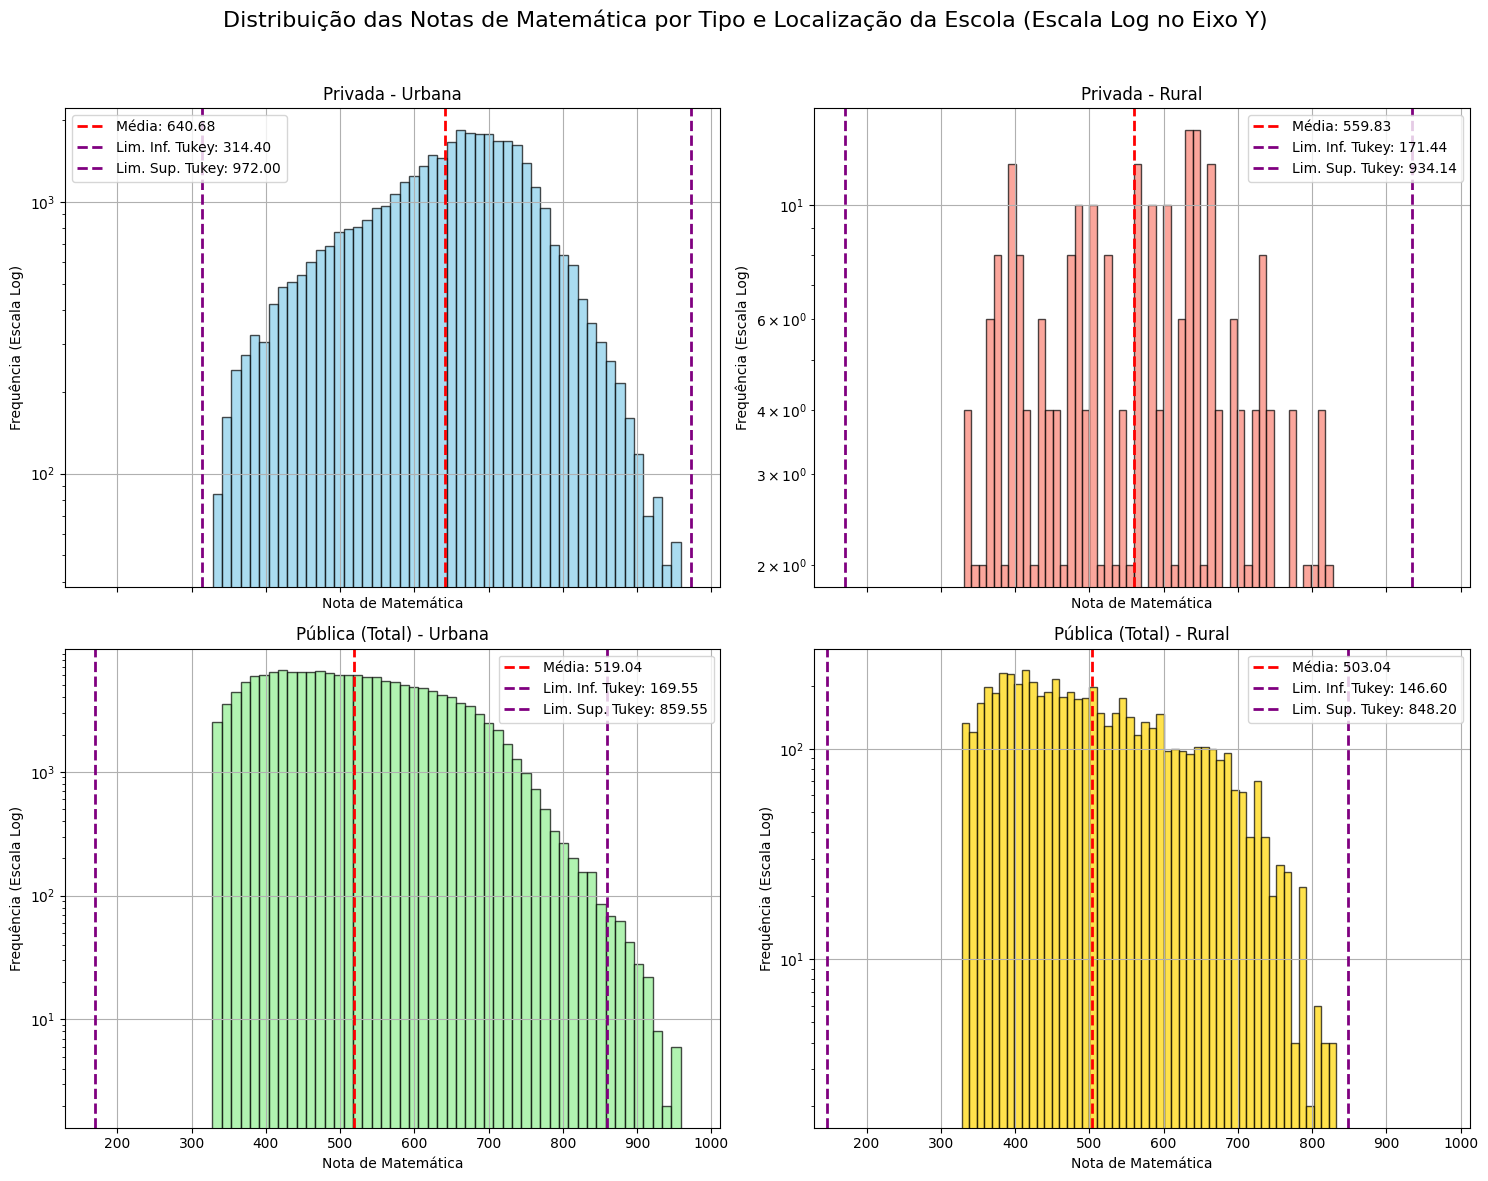

In [23]:
fig_hist, axes_hist = plt.subplots(2, 2, figsize=(15, 12), sharex=True)

plot_hist_with_tukey(axes_hist[0,0],
                        df_group[(df_group['TP_LOCALIZACAO_ESC'] == 'Urbana') &
                                                    (df_group['TP_DEPENDENCIA_ADM_ESC'] == 'Privada')]['NU_NOTA_MT'],
                        'Privada - Urbana', 'skyblue', 'Nota de Matemática', 'Frequência', use_log_scale=True)
plot_hist_with_tukey(axes_hist[0,1],
                        df_group[(df_group['TP_LOCALIZACAO_ESC'] == 'Rural') &
                                                    (df_group['TP_DEPENDENCIA_ADM_ESC'] == 'Privada')]['NU_NOTA_MT'],
                        'Privada - Rural', 'salmon', 'Nota de Matemática', 'Frequência', use_log_scale=True)
plot_hist_with_tukey(axes_hist[1,0],
                        df_group[(df_group['TP_LOCALIZACAO_ESC'] == 'Urbana') &
                                                    (df_group['TP_DEPENDENCIA_ADM_ESC'].isin(['Federal', 'Estadual', 'Municipal']))]['NU_NOTA_MT'],
                        'Pública (Total) - Urbana', 'lightgreen', 'Nota de Matemática', 'Frequência', use_log_scale=True)

plot_hist_with_tukey(axes_hist[1,1],
                        df_group[(df_group['TP_LOCALIZACAO_ESC'] == 'Rural') &
                                                    (df_group['TP_DEPENDENCIA_ADM_ESC'].isin(['Federal', 'Estadual', 'Municipal']))]['NU_NOTA_MT'],
                        'Pública (Total) - Rural', 'gold', 'Nota de Matemática', 'Frequência', use_log_scale=True)
fig_hist.suptitle('Distribuição das Notas de Matemática por Tipo e Localização da Escola (Escala Log no Eixo Y)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Analisando o gráfico, podemos ver que a quantidade de escolas localizadas na região rural é muito inferior às localizadas no meio urbano. Além disso, é possível visualizar a gigantesca vantagem em termos de notas das escolas privadas em relação às públicas como um todo, independente do meio. O limite de Tukey e a média evidenciam isso perfeitamente.

Assim, fica evidente que a categoria dominante no enem 2023 é disparadamente o aluno de escola privada, localizada no meio urbano. Isso nos leva a reflexões sobre a qualidade do ensino público como um todo no Brasil, além de evidenciar a necessidade de trazer escolas de maior qualidade para o campo.

### **"Como a escolha da língua estrangeira (TP_LINGUA) se relaciona com as notas em Linguagens e Códigos (NU_NOTA_LC)"**

In [37]:
# variáveis de interesse

var_names_LN = ['TP_LINGUA', 'NU_NOTA_LC']

# data frame filtrado

df_group:pd.DataFrame = df[var_names_LN]
df_group.dropna(inplace=True)
df_group = df_group[df_group["NU_NOTA_LC"] > 0]

/tmp/ipykernel_25529/666958580.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group.dropna(inplace=True)


In [38]:
# categorias
tp_dict = dict_microdados.legenda["TP_LINGUA"]

tp_lingua_map = {int(key) : descricao for key, descricao in zip(tp_dict["categoria"].values, tp_dict["descricao"].values)}


In [39]:
# mapear
df_group["TP_LINGUA"] = df_group["TP_LINGUA"].map(tp_lingua_map)

In [40]:
# media das notas

media_notas_tp = df_group.groupby("TP_LINGUA")['NU_NOTA_LC'].mean().sort_values(ascending=False)

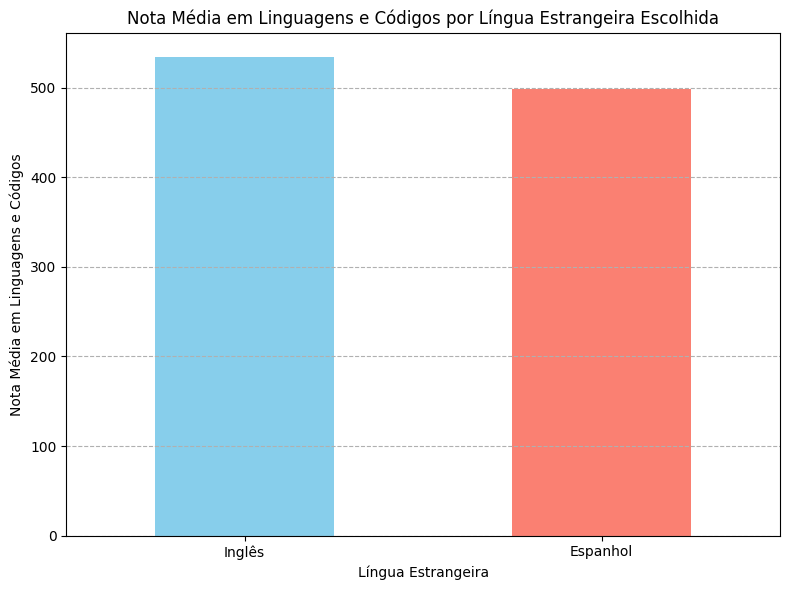

In [42]:
# plot data
plt.figure(figsize=(8, 6))
media_notas_tp.plot(kind="bar", color=['skyblue', 'salmon'])
plt.title('Nota Média em Linguagens e Códigos por Língua Estrangeira Escolhida')
plt.xlabel('Língua Estrangeira')
plt.ylabel('Nota Média em Linguagens e Códigos')
plt.xticks(rotation = 0)
plt.grid(axis='y', linestyle="--")
plt.tight_layout()
plt.show()


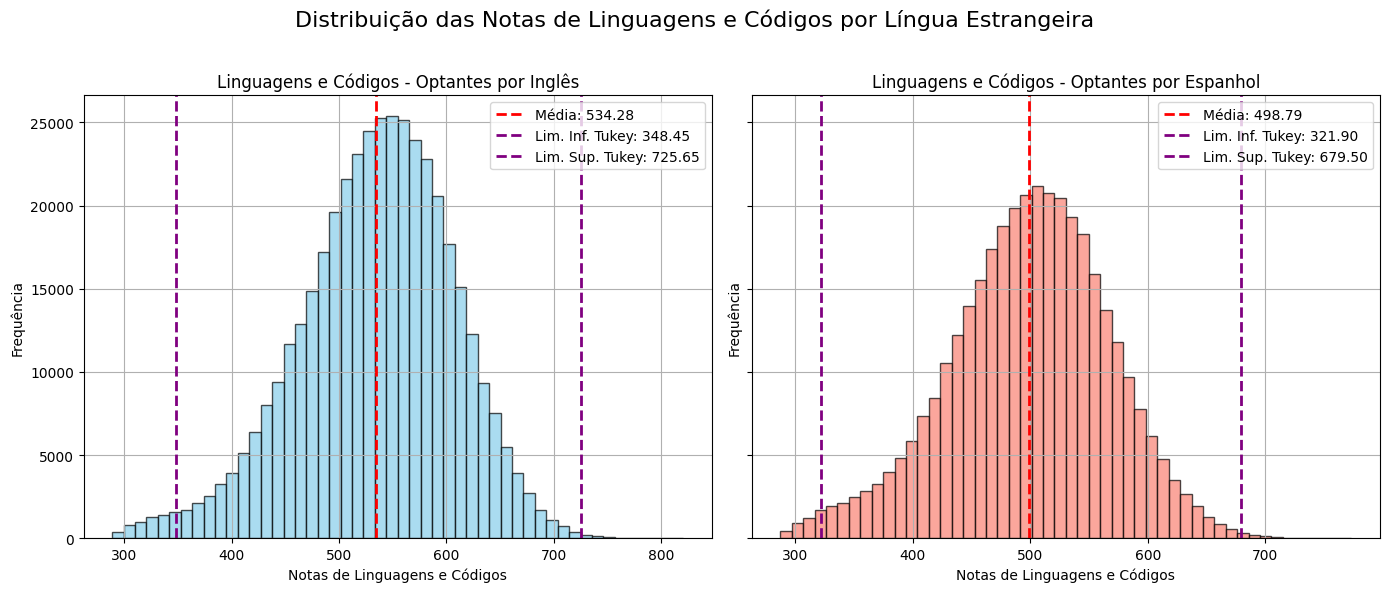

In [44]:
fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)

ingles_notas_lc = df_group[df_group['TP_LINGUA'] == "Inglês"]["NU_NOTA_LC"]
espanhol_notas_lc = df_group[df_group['TP_LINGUA'] == "Espanhol"]["NU_NOTA_LC"]

plot_hist_with_tukey(axes[0], ingles_notas_lc, 'Linguagens e Códigos - Optantes por Inglês', 'skyblue', 'Notas de Linguagens e Códigos', 'Frequência')
plot_hist_with_tukey(axes[1], espanhol_notas_lc, 'Linguagens e Códigos - Optantes por Espanhol', 'salmon', 'Notas de Linguagens e Códigos', 'Frequência')

fig.suptitle('Distribuição das Notas de Linguagens e Códigos por Língua Estrangeira', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Os dados sugerem que candidatos que escolheram Inglês como língua estrangeira tendem a ter um desempenho geral melhor na prova de Linguagens e Códigos em comparação com aqueles que optaram por Espanhol, com uma média em torno de 40 pontos a mais. Na análise dos histogramas gerados, é possível observar que ambas as distribuições se assemelham a uma curva normal. Porém, no gráfico referente aos optantes por Inglês, o pico da distribuição está visivelmente deslocado para a direita, indicando uma maior frequência de notas mais altas nesse grupo. Em contraste, a distribuição dos optantes por Espanhol tem seu pico em uma faixa de notas inferior.

Analisando os limites de Tukey, verificamos que no Inglês a maioria dos alunos típicos (desconsiderando outliers) ficou com notas entre 348,45 e 727,45. No Espanhol, a faixa típica foi entre 321,90 e 679,50. Essa diferença nos limites de Tukey reforça a observação de que o desempenho do grupo que optou por Inglês foi, no geral, melhor e teve uma faixa de notas mais elevadas.

### **"O estado civil apresenta alguma relação com a nota de matemática? Como isso é evidenciado quando olhamos faixas etárias específicas?"**

In [133]:
# variáveis de interesse
var_civ_faixa = ['TP_ESTADO_CIVIL', 'TP_FAIXA_ETARIA', 'NU_NOTA_MT']

In [134]:
# data frame com os dados de interesse

df_group = df[var_civ_faixa]
df_group.dropna(inplace=True)
df_group = df_group[df_group["NU_NOTA_MT"] > 0]

/tmp/ipykernel_25529/2427269902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group.dropna(inplace=True)


In [135]:
# variáveis categóricas

types_dict = {}
types_dict["TP_ESTADO_CIVIL"] = {
        1: 'Solteiro(a)',
        2: 'Casado(a)/Companheiro(a)'
    }
types_dict["TP_FAIXA_ETARIA"] = {
        'Até 25 anos': range(1, 11),
        '26 a 40 anos': range(11, 14),
        'Mais de 40 anos': range(14, 21)
    }

In [136]:
# Lista de faixas etárias com ordem preservada e sem duplicatas
lista_faixa = list(dict.fromkeys(types_dict["TP_FAIXA_ETARIA"].values()))

In [137]:
# filtrar valores informados para estado civil
df_group = df_group[df_group['TP_ESTADO_CIVIL'].isin(types_dict['TP_ESTADO_CIVIL'].keys())]

In [139]:
# mapear
def classificar_faixa(cod):
        for faixa, codigos in types_dict["TP_FAIXA_ETARIA"].items():
            if int(cod) in codigos:
                return faixa
            
df_group["TP_ESTADO_CIVIL"] = df_group["TP_ESTADO_CIVIL"].map(types_dict["TP_ESTADO_CIVIL"])
df_group["TP_FAIXA_ETARIA"] = df_group["TP_FAIXA_ETARIA"].apply(classificar_faixa)

In [141]:
palette = {
    'Solteiro(a)' : '#1f77b4',
    'Casado(a)/Companheiro(a)': '#ff7f0e'
}

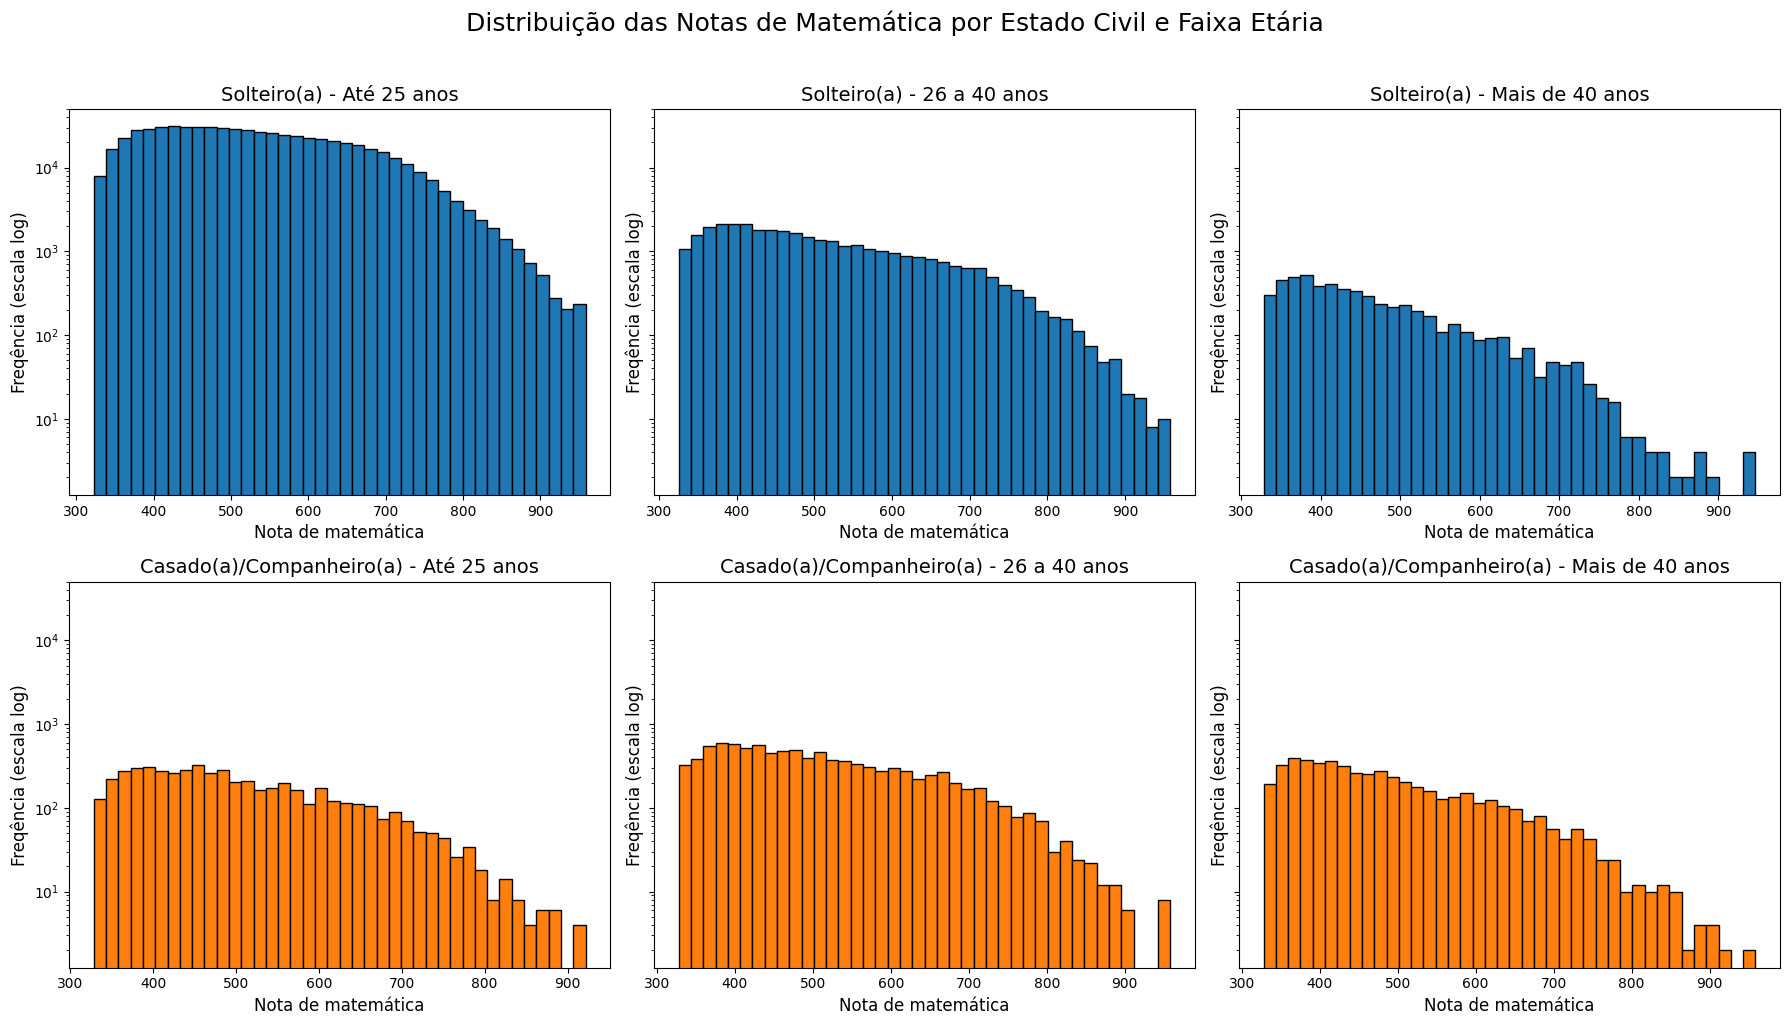

In [143]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axs = axs.flatten()

i = 0
for estado, cor in palette.items():
    for faixa in types_dict["TP_FAIXA_ETARIA"]:
        ax = axs[i]
        subset = df_group[(df_group["TP_ESTADO_CIVIL"] == estado) & (df_group["TP_FAIXA_ETARIA"] == faixa)]
        ax.hist(subset["NU_NOTA_MT"], bins = 40, color = cor, edgecolor = 'black', log=True)
        
        ax.set_title(f'{estado} - {faixa}', fontsize = 14)
        ax.set_xlabel('Nota de matemática', fontsize = 12)
        ax.set_ylabel('Freqência (escala log)', fontsize=12)
        i += 1
plt.suptitle('Distribuição das Notas de Matemática por Estado Civil e Faixa Etária', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
    

A partir da análise dos gráficos acima, é possível ver que, primeiro, a quantidade de pessoas solteiras em relação aos comprometidos é muito maior. 

Além disso, é possível perceber que a faixa etária tem um impacto evidente na nota, ao observamos que a regressão nos cenários de idades mais avançadas tem uma regressão mais acentuada do que as demais faixas

O estado civil parece ter impacto principalmente nos jovens até 25 anos, onde os solteiros(as) apresentam um desempenho relativamente melhor. Nas faixas etárias mais altas, essa diferença tende a se diluir, sugerindo que as demandas profissionais e familiares passam a ser os principais fatores que influenciam o desempenho acadêmico.